In [1]:
from data import *
from config import *
from classifer import *
from describer import *
print("using device: ", device)
random_state = 333
import pandas as pd
from sklearn.model_selection import train_test_split

# for debugging
# import importlib
# import models
# importlib.reload(models)


Random seed set to 333
using device:  cpu


In [2]:
# # ---- update configs ----
# overwrite = True
# model_name = 'binary_hr_death'
# text_config['cl']['die7d'] = True # udpate text_config here if needed
# txt_ls = ['will die', 'will survive']

# update_config(
#     model_name = model_name,
#     ts_aug = False,
#     ts_normalize = False,
#     ts_encode = False,
#     balance = False,
#     block_target = False,
#     txt_ls = txt_ls,
#     patience = 20,
#     num_saves = 20,
#     num_epochs = 100,
#     text_config = text_config
# )
# config_dict = get_config_dict()
# config_dict

In [3]:
# -----------------Train Data-----------------
df = pd.read_excel('../../data/PAS Challenge HR Data.xlsx', engine="calamine")
df.columns = df.columns.astype(str)
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df = label_death7d(df, df_y, id_col='VitalID')
df = df.merge(df_demo, on='VitalID', how='left')
df_desc = generate_descriptions_parallel(ts_df = df.loc[:, '1':'300'], id_df = df.loc[:, ['VitalID', 'VitalTime']])
df = df.merge(df_desc, on=['VitalID', 'VitalTime'], how='left')
df = text_gen_input_column(df, config_dict['text_config'])
df['rowid'] = df.index.to_series() 
df_train = df

# -----------------Test Data-----------------
df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
df_test = pd.read_excel('../../data/Test Data/Test HR Data.xlsx', sheet_name=0, engine="calamine") # test hr with description
df_test.columns = df_test.columns.astype(str)
df_test = label_death7d(df_test, df_y_test, id_col='TestID')
df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
df_test = df_test.merge(df_demo_test, on='TestID', how='left')
df_test['rowid'] = df_test.index.to_series()
df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
df_test['VitalTime'] = df_test['VitalTime'].astype(int)
rename_dict = {'TestID': 'VitalID'}
df_test = df_test.rename(columns=rename_dict)

df_desc_test = generate_descriptions_parallel(ts_df = df_test.loc[:, '1':'300'], id_df = df_test.loc[:, ['VitalID', 'VitalTime']])
df_test = df_test.merge(df_desc_test, on=['VitalID', 'VitalTime'], how='left')
df_test = text_gen_input_column(df_test, config_dict['text_config'])
df_test_org = df_test[df.columns]
df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org['cl_event'], random_state=random_state) 


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.6s
[Parallel(n_jobs=9)]: Done 2596 tasks      | elapsed:    5.1s
[Parallel(n_jobs=9)]: Done 62812 tasks      | elapsed:   13.0s
[Parallel(n_jobs=9)]: Done 65353 out of 65353 | elapsed:   13.3s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.  No Bradycardia events.   Very low amount of consecutive increases. 

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 9454 tasks      | elapsed:    1.4s
[Parallel(n_jobs=9)]: Done 41454 tasks      | elapsed:    5.2s
[Parallel(n_jobs=9)]: Done 61553 out of 61570 | elapsed:    7.5s remaining:    0.0s
[Parallel(n_jobs=9)]: Done 61570 out of 61570 | elapsed:    7.5s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.  No Bradycardia events.  It shows high variability.  Low amount of consecutive increases. 


In [4]:
txt_ls_org = ['This infant will die in 7 days. ', 'This infant will survive. ']
y_col = 'cl_event'
# ---- downsample negative class(es) ----
# sample 5000 rows from df_test[df_test[y_col]==txt_ls_org[1]], without replacement
neg_sample_size = 500
df_test_downsampled = df_test[df_test[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False)
df_test = pd.concat([df_test[df_test[y_col]==txt_ls_org[0]], df_test_downsampled])
df_train_downsampled = df_train[df_train[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False)
df_train = pd.concat([df_train[df_train[y_col]==txt_ls_org[0]], df_train_downsampled])


# ---- augment + balance train data----
target_event_rate = len(df_test[df_test[y_col]==txt_ls_org[0]])/len(df_test)
max_size = int(target_event_rate*len(df_train))
if config_dict['ts_aug']:
    df_train = augment_balance_data(df_train, 
                                    txt_ls_org, 
                                    y_col, 
                                    config_dict, 
                                    pretrained_model_path='./pretrained/hr_vae_linear_medium.pth', 
                                    K=10,
                                    max_size=max_size)


# ---- block or not ----
# important for generating labels for block target
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
if not config_dict['block_target']:
    df_train['label'] = df_train.index.to_series()
    df_test['label'] = df_test.index.to_series()
else:
    df_train['label'] = df_train['rowid'].astype(int)
    df_test['label'] = df_test['rowid'].astype(int)

def get_y_true_and_ts_df(df_new, txt_ls_org):
    df_new_y = pd.get_dummies(df_new['cl_event'])
    df_new_y = df_new_y[txt_ls_org]
    y_true = torch.tensor(df_new_y.values)
    ts_df = df_new.loc[:,'1':'300']
    return y_true, ts_df

y_true_train, ts_df_train = get_y_true_and_ts_df(df_train, txt_ls_org)     # create y_true_train and ts_df_train
y_true_test, ts_df_test = get_y_true_and_ts_df(df_test, txt_ls_org)     # create y_true_test and ts_df_test
print(ts_df_train.shape)
print(ts_df_test.shape)


y_true_train = y_true_train.float()
y_true_test = y_true_test.float() 
train_loader = prepare_basedata(ts_df_train, y_true_train)
test_loader = prepare_basedata(ts_df_test, y_true_test)

# get number of positives in y_true_train
pos_count = (y_true_train[:,0] == 1).sum().item()
print(f"Number of positives in y_true_train: {pos_count}")

# get number of positives in y_true_test
pos_count = (y_true_test[:,0] == 1).sum().item()
print(f"Number of positives in y_true_test: {pos_count}")


(884, 300)
(741, 300)
Number of positives in y_true_train: 384
Number of positives in y_true_test: 241


# baseline models to predict clinical outcomes end2end

In [6]:
class MLPEncoder(nn.Module):
    def __init__(self, ts_dim, output_dim, hidden_dim=128, num_hidden_layers=6, dropout=0.2):
        """
        Multi-layer perceptron encoder.
        
        Args:
            ts_dim (int): Input time series length
            output_dim (int): Output dimension
            hidden_dim (int): Hidden dimension
            num_hidden_layers (int): Number of hidden layers
            dropout (float): Dropout rate
        """
        super().__init__()
        
        layers = []
        
        if num_hidden_layers > 0:
            # First hidden layer (input projection)
            layers.extend([
                nn.Linear(ts_dim, hidden_dim),
                nn.LeakyReLU(0.2),
                nn.Dropout(dropout)
            ])
        
            # Hidden layers
            if num_hidden_layers > 1:
                for _ in range(num_hidden_layers - 1):
                    layers.extend([
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(dropout)
                    ])
        else:
            hidden_dim = ts_dim
        
        # Final projection - extend instead of append for list of layers
        layers.extend([
            nn.Linear(hidden_dim, output_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout)
        ])
        
        self.encoder = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.encoder(x)

In [25]:
# # Create different types of models
# resnet_encoder = ResNetEncoder(ts_dim=300, output_dim=16, num_blocks=1, dropout=0.5)
# model = GeneralBinaryClassifier(resnet_encoder)

mlp_encoder = MLPEncoder(ts_dim=300, output_dim=128, hidden_dim=32, num_hidden_layers=1, dropout=0.5)
model = GeneralBinaryClassifier(mlp_encoder)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Reduce LR when metric stops decreasing
    factor=0.9,          # Multiply LR by this factor
    patience=20,          # Number of epochs to wait before reducing LR
    min_lr=1e-20         # Don't reduce LR below this value
)


Layer (type:depth-idx)                   Param #
GeneralBinaryClassifier                  --
├─MLPEncoder: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  9,632
│    │    └─LeakyReLU: 3-2               --
│    │    └─Dropout: 3-3                 --
│    │    └─Linear: 3-4                  4,224
│    │    └─LeakyReLU: 3-5               --
│    │    └─Dropout: 3-6                 --
├─Linear: 1-2                            258
Total params: 14,114
Trainable params: 14,114
Non-trainable params: 0


Epoch [1/500]
	Train Loss: 0.7200	Test Loss: 0.7205
	Train F1: 0.5417	Test F1: 0.4632
	Train AUROC: 0.4597	Test AUROC: 0.4790
	Train AUPRC: 0.4028	Test AUPRC: 0.3187
	Learning Rate: 0.000100000
Epoch [2/500]
	Train Loss: 0.7125	Test Loss: 0.7140
	Train F1: 0.5326	Test F1: 0.4425
	Train AUROC: 0.4652	Test AUROC: 0.4813
	Train AUPRC: 0.4061	Test AUPRC: 0.3201
	Learning Rate: 0.000100000
Epoch [3/500]
	Train Loss: 0.7130	Test Loss: 0.7090
	Train F1: 0.5195	Test F1: 0.4343
	Train AUROC: 0.4713	Test AUROC: 0.4829
	Train AUPRC: 0.4092	Test AUPRC: 0.3209
	Learning Rate: 0.000100000
Epoch [4/500]
	Train Loss: 0.7153	Test Loss: 0.7043
	Train F1: 0.5048	Test F1: 0.4127
	Train AUROC: 0.4772	Test AUROC: 0.4840
	Train AUPRC: 0.4131	Test AUPRC: 0.3228
	Learning Rate: 0.000100000
Epoch [5/500]
	Train Loss: 0.7075	Test Loss: 0.6997
	Train F1: 0.4736	Test F1: 0.4059
	Train AUROC: 0.4834	Test AUROC: 0.4873
	Train AUPRC: 0.4162	Test AUPRC: 0.3241
	Learning Rate: 0.000100000
Epoch [6/500]
	Train Loss: 0.7

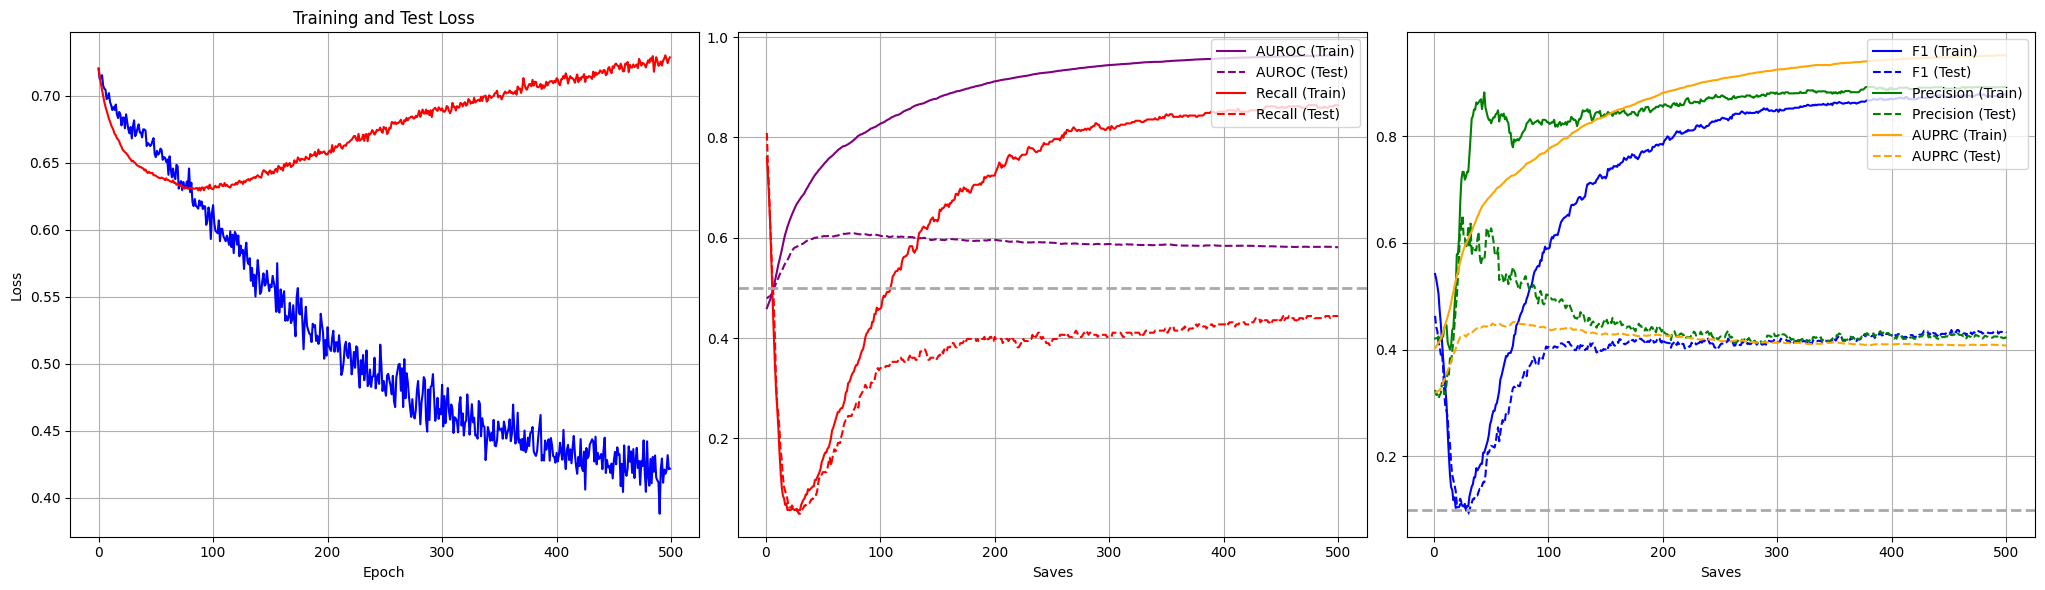

In [26]:

eval_dic_tmp, train_losses_tmp, test_losses_tmp = train_binary_classifier(model, 
                                                train_loader,
                                                test_loader, 
                                                optimizer, 
                                                scheduler,
                                                500, 
                                                device)
eval_dict_eng = eng_eval_metrics(eval_dic_tmp, binary=True)

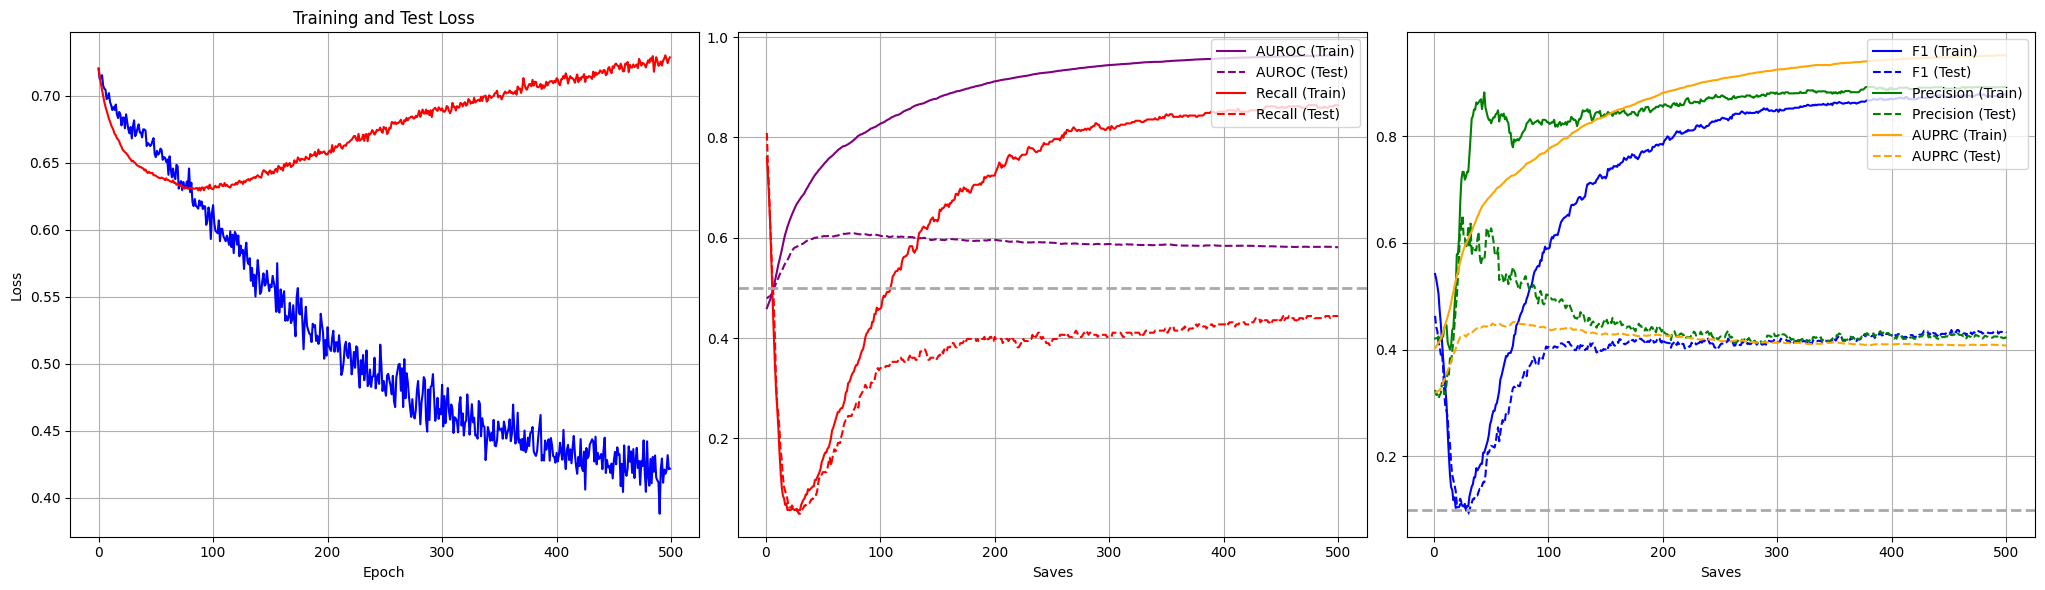

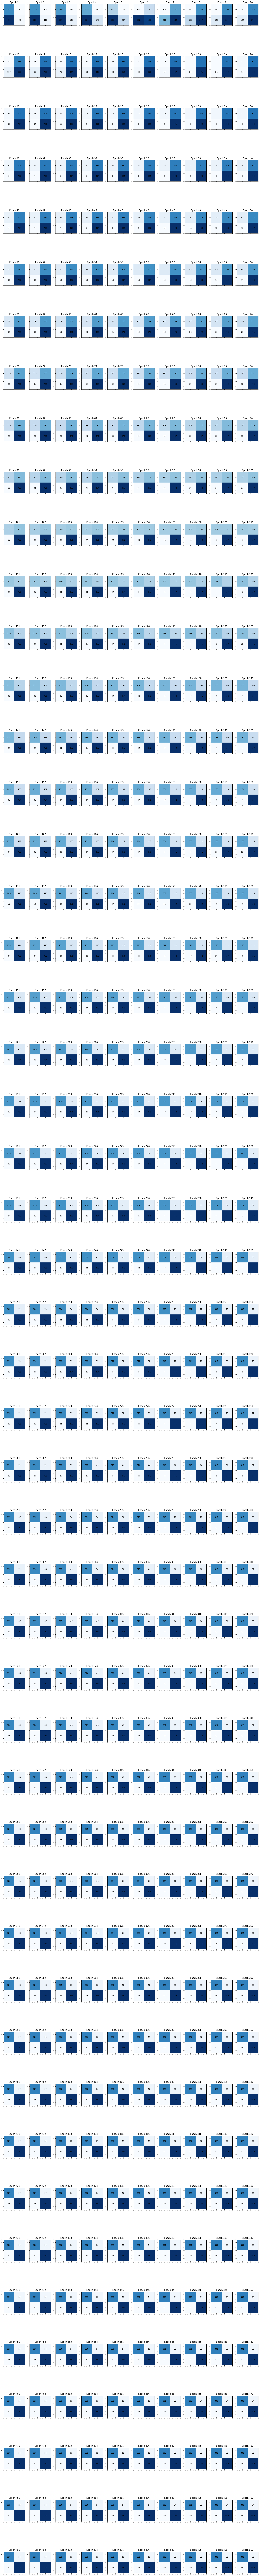

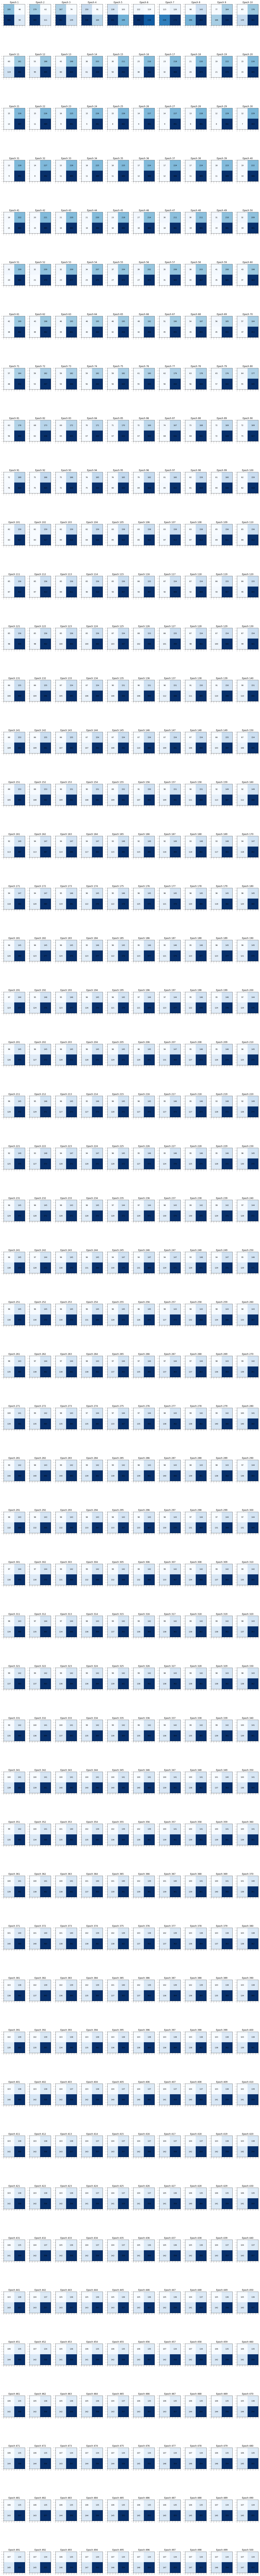

In [27]:

eval_dict_eng = eng_eval_metrics(eval_dic_tmp, binary=True, plot_confusion_matrices=True)

In [ ]:

# train_eval_metrics_list = []
# test_eval_metrics_list = []
# train_losses = []
# test_losses = []

# if overwrite or not os.path.exists(model_path):
    
#     for i in range(config_dict['num_saves']): 
#         eval_dic_tmp, train_losses_tmp, test_losses_tmp = train_binary_classifier(model, 
#                                                 train_loader,
#                                                 test_loader, 
#                                                 optimizer, 
#                                                 scheduler,
#                                                 config_dict['num_epochs'], 
#                                                 device)
#         train_losses = train_losses + train_losses_tmp
#         test_losses = test_losses + test_losses_tmp

#         train_metrics, test_metrics = eval_binary_classifier(model, 
#                                                              train_loader, 
#                                                              test_loader, 
#                                                              device)
#         train_eval_metrics_list.append(train_metrics)
#         test_eval_metrics_list.append(test_metrics)
#         # save model and losses
#         torch.save(model.state_dict(), model_path)
#         torch.save({'train_losses': train_losses, 
#                     'test_losses': test_losses, 
#                     'train_evals': train_eval_metrics_list, 
#                     'test_evals': test_eval_metrics_list}, eval_path)
#         if i % 10 == 0: # every 10 saves, evaluate the model
#             eval_dict = torch.load(eval_path)
#             eval_dict_eng = eng_eval_metrics(eval_dict, binary=True)
#             print("-" * 70)
#             print(f"Metric     |  Training  |  Testing")
#             print("-" * 70)
#             print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
#             print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
#             print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
#             print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
#             print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
#             print("-" * 70)
    
# else:
#     model.load_state_dict(torch.load(model_path))
#     eval_dict = torch.load(eval_path)
#     train_losses = eval_dict['train_losses']
#     test_losses = eval_dict['test_losses']
#     train_eval_metrics_list = eval_dict['train_evals']
#     test_eval_metrics_list = eval_dict['test_evals']
#     eval_dict_eng = eng_eval_metrics(eval_dict, binary=True, plot_confusion_matrices=True)